<a href="https://colab.research.google.com/github/hrkzz/StateSpaceModel/blob/master/Analysing_effects_of_advertisement_by_dynamic_linear_model_and_pystan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ライブラリのインポート

In [0]:
#基本ライブラリ
import numpy as np
import pandas as pd

#図形描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

from matplotlib.pylab import rcParams

#統計ライブラリ
import pystan

#シミュレーションデータ

In [0]:
#サンプルサイズ
N = 450

#乱数固定
np.random.seed(10)

#時間によって変化する広告効果
true_reg_coef = -np.log(np.arange(1,51))*2+10

#ランダムウォークする水準値（トレンド）
mu = np.cumsum(np.random.normal(loc=0, scale=0.5, size=N)) + 25

#状態方程式
x = mu + np.concatenate((np.repeat(0,200),true_reg_coef, np.repeat(0,200)))

#観測誤差
obs_error = np.random.normal(loc=0, scale=2, size=N)

#観測値（広告効果が入った売上データ）
sales_ad = x + obs_error

#説明変数（1なら広告あり）
dummy_ad = np.zeros(N)
dummy_ad[201:251] = 1

#データフレームで整理
data = pd.DataFrame(dict(sales_ad=sales_ad, dummy_ad=dummy_ad))

In [0]:
data.head()

,sales_ad,dummy_ad
0,22.834287,0.0
1,26.212849,0.0
2,25.638334,0.0
3,26.333011,0.0
4,25.669880,0.0


##図示

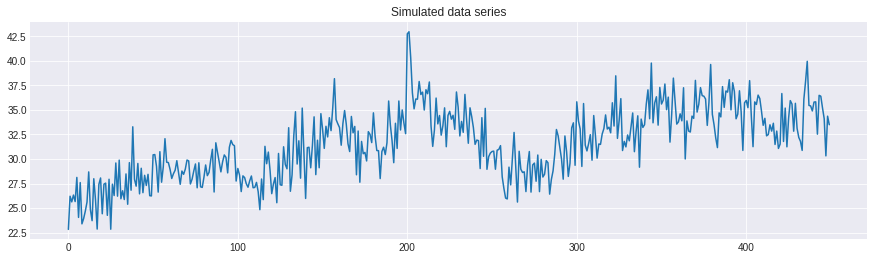

In [20]:
rcParams['figure.figsize'] = 15,4
plt.plot(data.sales_ad)
plt.title('Simulated data series')
plt.show()

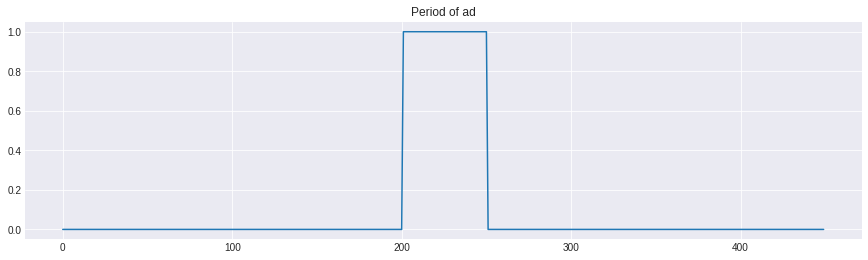

In [21]:
rcParams['figure.figsize'] = 15,4
plt.plot(data.dummy_ad)
plt.title('Period of ad')
plt.show()

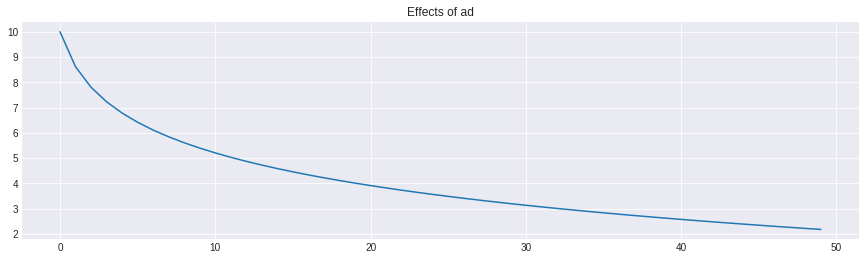

In [22]:
rcParams['figure.figsize'] = 15,4
plt.plot(true_reg_coef)
plt.title('Effects of ad')
plt.show()

#モデリング

状態空間モデルを使って推定を行っていきたいと思います。このモデルでは、回帰係数が時間よって変化する時変係数のモデリングが可能となっていて、時間とともにその効果が薄れていくことを表現することが可能です。<br>
状態空間モデルのローカルレベルモデルに、広告効果に関する時変の説明変数を付け加えた、以下のモデルを使っていきます。広告効果のダミー変数の係数の右下に$t$と付けていますが、これが時変係数を表しています。

$$
\begin{align}
  \beta_t &= \beta_{t-1} + a_t&a_t \sim Normal(0,\sigma^2_a) \\
  \mu_t &= \mu_{t-1} + w_t &w_t \sim Normal(0,\sigma^2_w)  \\
  y_t &= \mu_t + a_t*dummy\_ad_t+v_t &v_t \sim Normal(0,\sigma^2_v) 
\end{align}
$$
<br>
これを別の書き方にすると、
<br>
$$
\begin{align}
  \beta_t &\sim Normal(\beta_{t-1},\sigma^2_a)  \\
  \mu_t &\sim Normal(\mu_{t-1},\sigma^2_w)  \\
  y_t &\sim  Normal(\mu_t +  a_t*dummy\_ad_t,\sigma^2_v) 
\end{align}
$$


##Stanの実装

Stanの式は次のとおり。なお、Stanでは事前分布を指定しないと自動的に制限された範囲内で十分に幅の広い一様分布が使われるようです。

In [0]:
Effect_ad_model = '''
data{
    int<lower=0> N;
    real<lower=0> sales_ad[N];
    real<lower=0, upper=1> dummy_ad[N];
}

parameters{
    real<lower=0> s_a;
    real<lower=0> s_w;
    real<lower=0> s_v;
    real beta_zero;
    real beta[N];
    real mu_zero;
    real mu[N];
}

model{
    beta[1] ~ normal(beta_zero, s_a);
    
    for(i in 2:N)
      beta[i] ~ normal(beta[i-1], s_a);
    
    mu[1] ~ normal(mu_zero, s_w);
    
    for(i in 2:N)
      mu[i] ~ normal(mu[i-1], s_w);
    
    for(i in 1:N)
      sales_ad[i] ~ normal(mu[i] + beta[i]*dummy_ad[i], s_v);
}
'''

上記のstanファイルを直接読み込んでもいいのですが、コンパイルと乱数発生を別にして、乱数発生を色々試したかったので、外からstanファイルを読み込むことにします。読み込み方はGoogle Colab流です。

In [29]:
from google.colab import files
uploaded = files.upload()

Saving Effect_ad_model.stan to Effect_ad_model.stan


まずはstanファイルのコンパイル。

In [30]:
stanmodel = pystan.StanModel(file='Effect_ad_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_883d422f9f425c3ce85e7b9851134b2f NOW.


データをstanに優しい形式にして、実行。BUGSなどのほかのパッケージに比べてStanはMCMCの自己相関が低いらしく、thinは1でも問題ないことが多いらしいですが、今回はthinを2にしておきます。

In [32]:
data_stan = dict(N=N, sales_ad=data.sales_ad, dummy_ad=data.dummy_ad)
fit = stanmodel.sampling(data=data_stan, iter=2000, warmup=500, chains=4, thin=2, seed=1, n_jobs=-1)

#推定結果の解釈

1行目はモデルのファイル名<br>
2行目にはMCMCのchain数、iterationのステップ数、warmupのステップ数、thinningのステップ数が表示。今回はデフォルトの設定。MCMCのサンプルの長さは<br><br>
$$
  \frac{chains*(iterations - warmup)}{thinning}
$$
<br>
になるので、今回は4000となります。

meanはMCMCのサンプルの平均値で事後平均。se_meanはmeanの標準誤差。sdは標準偏差。2.5%～97.5%はそれぞれの分位点。n_effはStanが自己相関等から判断した実効的なMCMCサンプル数。著者によると100くらいが望ましいです。RhatはMCMCの収束の判断のひとつ。1.1以下だと収束とみなせます。<br>
今回はn-effはだいたい十分で、Rhatを見ると、うまく収束しているようです。

In [34]:
print(fit)

Inference for Stan model: anon_model_883d422f9f425c3ce85e7b9851134b2f.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_a         0.48    0.11   0.27   0.08   0.25   0.47   0.68    1.0      6   1.44
s_w         0.45  7.2e-3   0.07   0.33    0.4   0.44   0.49   0.61     99   1.06
s_v         1.87  2.0e-3   0.07   1.73   1.82   1.87   1.92   2.02   1313    1.0
beta_zero   4.22    0.44   7.98 -11.63    0.2   3.44   7.75  23.78    334   1.01
beta[1]     4.22    0.44   7.97  -11.6   0.18   3.35    7.7  23.78    329   1.01
beta[2]     4.22    0.44   7.93 -11.26   0.26   3.35   7.67  23.72    326   1.01
beta[3]     4.22    0.44    7.9 -11.25   0.28   3.33   7.67  23.61    324   1.01
beta[4]     4.22    0.44   7.88 -11.29   0.24   3.29   7.66   23.3    324   1.01
beta[5]     4.21    0.44   7.87 -11.23   0.21   3.36   7.65   23.4    320   1.01
bet

##Traceplot
Traceplotでも収束具合を確認

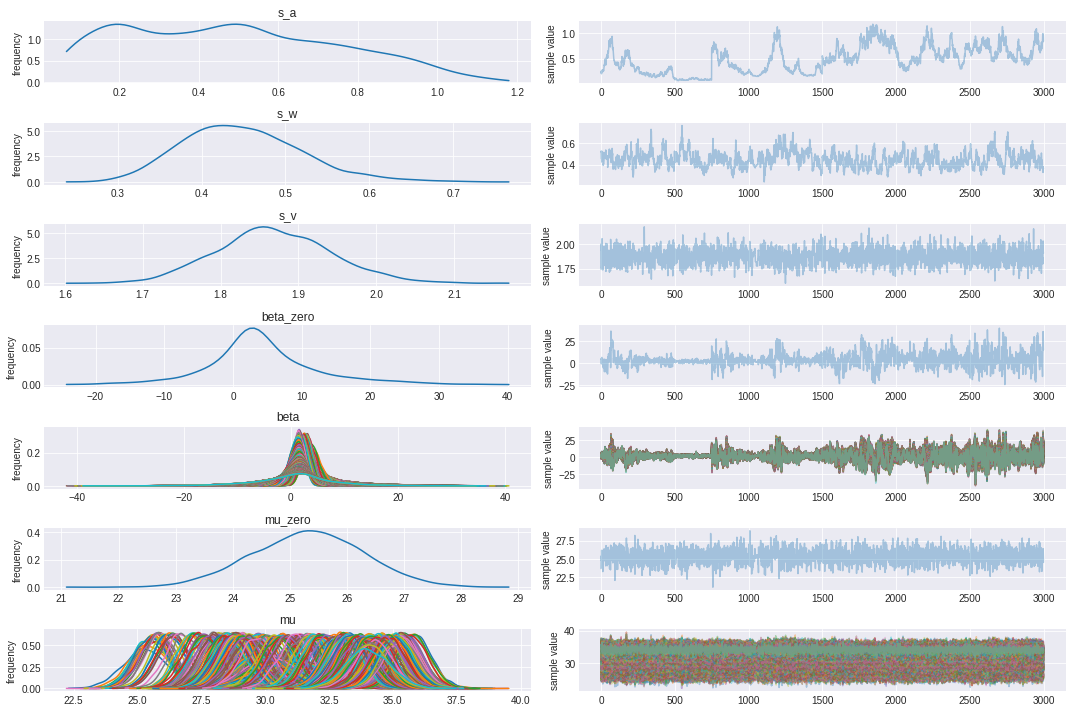

In [35]:
rcParams['figure.figsize'] = 15, 10
fit.plot()
plt.tight_layout()
plt.show()

#図示

In [0]:
#結果を抽出
ms = fit.extract() 

#muの事後平均を算出
mu_mean = ms['mu'].mean(axis=0)

#広告効果の回帰係数の事後平均を算出
beta_mean = ms['beta'].mean(axis=0)

#広告効果を算出
ad_effects = beta_mean*data.dummy_ad

###トレンド

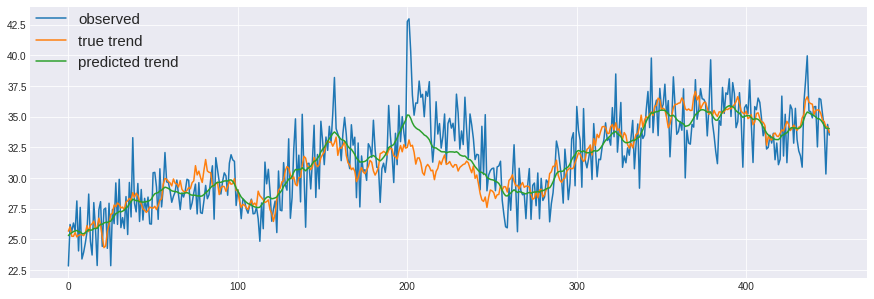

In [38]:
rcParams['figure.figsize'] = 15, 5

plt.plot(data.sales_ad, label='observed')
plt.plot(mu, label='true trend')
plt.plot(mu_mean, label='predicted trend')
plt.legend(loc='upper left', borderaxespad=0, fontsize=15)

###広告効果

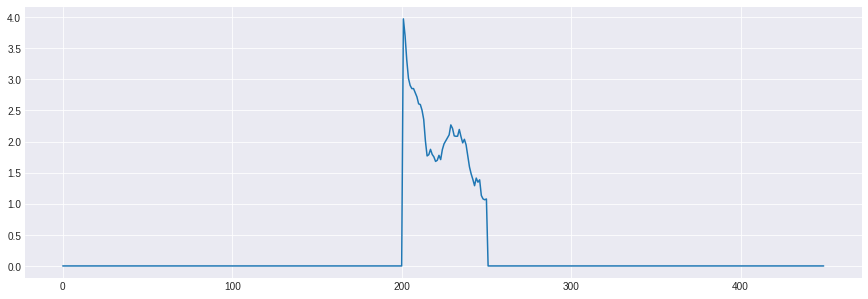

In [39]:
plt.plot(ad_effects)

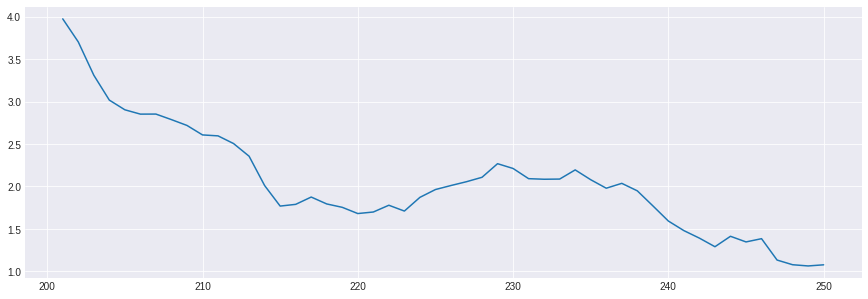

In [40]:
#該当部分のみ拡大
plt.plot(ad_effects[201:251])

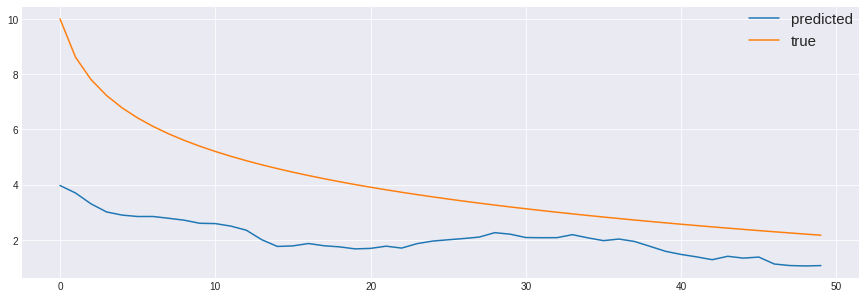

In [43]:
#真の係数と比較
plt.plot(np.array(ad_effects[201:251]), label='predicted')
plt.plot(true_reg_coef, label='true')
plt.legend(loc='upper right', borderaxespad=0, fontsize=15)

右肩下がりは示せていますが、事後平均は真の効果の半分くらいになってますね。